<a href="https://colab.research.google.com/github/m4rk-lewis/GPT-3_breaking_news_parse_with_sentiment_classify/blob/main/GPT_3_breaking_financial_news_summary_and_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# credit to: @m4rk-lewis https://github.com/m4rk-lewis/GPT-3_breaking_news_parse_with_sentiment_classify

# Step 1: Install required packages
!pip install feedparser beautifulsoup4 openai


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Step 2: Download and parse the RSS feed
import feedparser
def get_feed(url):
    return feedparser.parse(url)

In [3]:
# Step 3: Extract HTML from the description
from bs4 import BeautifulSoup

def extract_text(html):
    soup = BeautifulSoup(html, "html.parser")
    return soup.get_text()

In [25]:
from dotenv import load_dotenv
load_dotenv()
import os
import openai

# openai.api_key = "insert-openAI-API-here"
openai.api_key = os.environ.get("api_key")

# Step 4: Summarize using GPT-3
def summarize_text(text):
    response = openai.Completion.create(
        engine="text-davinci-003", 
        prompt=f"Summarize the following text: {text}",
        temperature=0.3,
        max_tokens=50,
        top_p=1,
        frequency_penalty=0.0,
        presence_penalty=0,
    )
    return response.choices[0].text.strip()

# Step 5: Sentiment classification
def sentiment_classification(text):
    response = openai.Completion.create(
        engine="text-davinci-003", 
        prompt=f"classify the sentiment of this breaking financial news article as a numerical float, with a range of -1 to 1 with 0.1 granularity, where -1 is maximum bearishness and 1 is maximum bullishness in relation to equities, reply only the float number as requested, do not include any text in the response: {text}",       
        temperature=0.3,
        max_tokens=10,
        top_p=1,
        frequency_penalty=0.0,
        presence_penalty=0,
    )
    sentiment_str = response.choices[0].text.strip()
    try:
        sentiment = float(sentiment_str)
    except ValueError:
        sentiment = None
    return sentiment

In [26]:
# Step 6: Store the summarized information in a SQLite database
import sqlite3

def create_db():
    conn = sqlite3.connect('eth_ct_rss.db')
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS news (published TEXT, title TEXT, summary TEXT, sentiment TEXT)''')
    return conn, cursor

def insert_news(cursor, published, title, summary, sentiment):
    cursor.execute("INSERT INTO news (published, title, summary, sentiment) VALUES (?, ?, ?, ?)", (published, title, summary, sentiment))
    # Commit the changes to the database
    conn.commit()

In [27]:
# Step 7: Continuously monitor the RSS feed for updates
import time

def monitor_feed(url, conn, cursor
                 # , interval=60
                 ):
    seen_titles = set()
    
    while True:
        feed = get_feed(url)
        # print(feed.entries[0])
        for entry in feed.entries:
            title = entry.title
            if title not in seen_titles:
                # if entry.category == "News" or entry.category =="Central Banks":
                    seen_titles.add(title)
                    category = extract_text(entry.category)
                    published = extract_text(entry.published)
                    description = extract_text(entry.description)
                    summary = summarize_text(description[:4000])
                    sentiment = sentiment_classification(description[:4000])
                    insert_news(cursor, published, title, summary, sentiment)  
                    print(f"{published}>>> {category}  >>> {title} >>> Summary: {summary} >>> Sentiment: {sentiment}")
                          
        # Close the database connection and sleep
        conn.close()
        #time.sleep(interval)

In [28]:
'''
# This code will download the RSS feed and process new entries every 60 seconds. 
Adjust the interval parameter in monitor_feed() to control how often the feed is checked.
'''
if __name__ == "__main__":
    url = "https://cointelegraph.com/rss/tag/ethereum"
    conn, cursor = create_db()
    monitor_feed(url, conn, cursor)


Tue, 09 May 2023 16:56:59 +0100>>> PayPal  >>> PayPal’s crypto holdings increased by 56% in Q1 2023 to nearly $1B >>> Summary: Fintechs hold $861M in BTC and ETH, up 56% since Q4 2022. >>> Sentiment: 0.7
Tue, 09 May 2023 14:30:00 +0100>>> Features  >>> $3.4B of Bitcoin in a popcorn tin: The Silk Road hacker’s story >>> Summary: Hacker stole billions and lived luxuriously for 10 years until caught due to small transaction. >>> Sentiment: -0.2
Tue, 09 May 2023 01:50:14 +0100>>> Memecoin  >>> Worth it? Trader spends $120K on gas buying $155K worth of a memecoin >>> Summary: User spent 76% more in gas fees on a single memecoin trade. >>> Sentiment: -0.5
Mon, 08 May 2023 17:00:00 +0100>>> Aave  >>> Aave v3 launches on Ethereum layer-2 network Metis >>> Summary: Big players in DeFi sector are deploying liquidity protocol Aave on Ethereum scaling network Metis. >>> Sentiment: 0.7
Mon, 08 May 2023 14:30:00 +0100>>> Columns  >>> ‘Ethical’ SBF game axed, Web3 games sign-up process sucks, Tomb Ch

KeyboardInterrupt: 

In [1]:
import sqlite3
import pandas as pd
from datetime import datetime

# create a connection
con = sqlite3.connect('eth_ct_rss.db')
data = pd.read_sql_query('Select * from news WHERE sentiment IS NOT NULL;', con)

data['sentiment'] = data['sentiment'].astype(float)
# parse_format = "%a, %d %b %Y %H:%M:%S %z"
# format_output = "%m-%d %H:%M" # %Y-%m-%d %H:%M:%S
# data['published'] = data['published'].apply(lambda x: datetime.strptime(x, parse_format).strftime(format_output))

data.head()

,published,title,summary,sentiment
0,"Tue, 09 May 2023 16:56:59 +0100",PayPal’s crypto holdings increased by 56% in Q...,"Fintechs hold $861m in BTC and ETH, up 56% sin...",0.7
1,"Tue, 09 May 2023 14:30:00 +0100",$3.4B of Bitcoin in a popcorn tin: The Silk Ro...,"Hacker stole billions, spent a decade living h...",-0.5
2,"Tue, 09 May 2023 01:50:14 +0100",Worth it? Trader spends $120K on gas buying $1...,User spent 76% of purchase price on gas fees f...,-0.4
3,"Mon, 08 May 2023 17:00:00 +0100",Aave v3 launches on Ethereum layer-2 network M...,"Aave, a liquidity protocol, deploys on Metis, ...",0.8
4,"Mon, 08 May 2023 14:30:00 +0100","‘Ethical’ SBF game axed, Web3 games sign-up pr...","FTX kills Storybook Brawl, Animoca gets MMA ga...",0.0


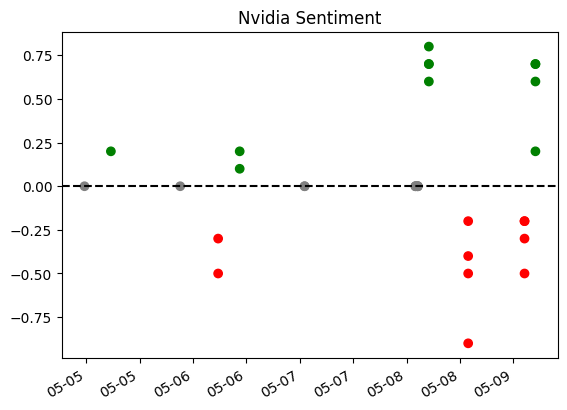

In [3]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

data['published'] = pd.to_datetime(data['published'])
sorted_data = data.sort_values('published')

# Convert sentiment column to numeric type
sorted_data['sentiment'] = pd.to_numeric(sorted_data['sentiment'])

colors = ['red' if val < 0 else 'green' if val > 0 else 'grey' for val in sorted_data['sentiment']]

fig, ax = plt.subplots()
ax.scatter(sorted_data['published'], sorted_data['sentiment'], color=colors)

# Set the x-axis formatter to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) #Y-%m-%d

# Auto-rotate the x-axis labels for better readability
fig.autofmt_xdate()
 
plt.axhline(0, color='black', linestyle='--')

plt.title('Nvidia Sentiment')
 
plt.show()